In [1]:
# Figure 4

In [2]:
import itertools
import warnings

import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import xarray as xr

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
region_name_dicts = {5: 'ENA', 17: 'WCE', 58: 'NEA'}
simulation_name_dicts = {'ref': 'Historical', 'refshort': 'High-warming', 'pol3.7short': 'Low-warming'}

In [4]:
ref_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.Emissions.april-august.nc4")
refshort_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.Emissions.april-august.nc4")
polshort_ds_emis = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.Emissions.april-august.nc4")

data_arrays_emis = [ref_ds_emis, refshort_ds_emis, polshort_ds_emis]

ref_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.SpeciesConc.april-august.nc4")
refshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.SpeciesConc.april-august.nc4")
polshort_ds_spec = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.SpeciesConc.april-august.nc4")

data_arrays_spec = [ref_ds_spec, refshort_ds_spec, polshort_ds_spec]

In [5]:
def get_regional_data(ds, my_variable, my_simulation, months, scale_factor):
    da = ds[my_variable]
    da = tools.mask_ocean_c48(da)
    da = da.sel(time=da.time.dt.month.isin(months))
    da = da.resample(time='1Y').mean() * scale_factor
    da = da.stack(new_dim=['sim', 'time'])
    da['name'] = simulation_name_dicts[my_simulation]

    #EUS: 
    region_num = 5
    da_EUS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EUS = da_EUS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EUS['region_name'] = region_name_dicts[region_num]

    #WCE: 
    region_num = 17
    da_WCE = tools.crop_regionmask_ar6_c48(da, region_num)
    da_WCE = da_WCE.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_WCE['region_name'] = region_name_dicts[region_num]

    #EAS: 
    region_num = 58
    da_EAS = tools.crop_regionmask_ar6_c48(da, region_num)
    da_EAS = da_EAS.mean(dim=['nf', 'Ydim', 'Xdim'])
    da_EAS['region_name'] = region_name_dicts[region_num]

    da_all = xr.concat([da_EUS, da_WCE, da_EAS],dim='concat_dim')
    return da_all

In [6]:
def get_dataframe(my_variable, data_arrays, months, scale_factor):

    if my_variable == "SpeciesConc_HOx":
        ref_HO2 = get_regional_data(data_arrays[0], "SpeciesConc_HO2", "ref", months, scale_factor)
        ref_OH = get_regional_data(data_arrays[0], "SpeciesConc_OH", "ref", months, scale_factor)
        ref = (ref_HO2+ref_OH)

        refshort_HO2 = get_regional_data(data_arrays[1], "SpeciesConc_HO2", "refshort", months, scale_factor)
        refshort_OH = get_regional_data(data_arrays[1], "SpeciesConc_OH", "refshort", months, scale_factor)
        refshort = (refshort_HO2+refshort_OH)

        polshort_HO2 = get_regional_data(data_arrays[2], "SpeciesConc_HO2", "pol3.7short", months, scale_factor)
        polshort_OH = get_regional_data(data_arrays[2], "SpeciesConc_OH", "pol3.7short", months, scale_factor)
        polshort = (polshort_HO2+polshort_OH)

        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe(name="SpeciesConc_HOx")
    else:    
        ref = get_regional_data(data_arrays[0], my_variable, "ref", months, scale_factor)
        refshort = get_regional_data(data_arrays[1], my_variable, "refshort", months, scale_factor)
        polshort = get_regional_data(data_arrays[2], my_variable, "pol3.7short", months, scale_factor)
        df = xr.concat([ref, polshort, refshort],dim='concat_dim').to_dataframe()
    return df 

In [8]:
months = [4,5,6,7,8]
# kgNO/m2/s to gN/m2/year 
# 1000g/kg * (14/30) kgN/kgNO * 86400 s/day * 153 April-August days/year
scale_factor = 1000 * (14/30) * 86400 * (153)
EmisNO_Soil_df = get_dataframe("EmisNO_Soil", data_arrays_emis, months, scale_factor)

# kgNO/m2/s to gC/m2/year 
# 1000g/kg * (60.06/68.12) kgC/kgISOP * 86400 s/day * 153 April-August days/year
scale_factor = 1000 * (60.06/68.12)  * 86400 * (153)

EmisISOP_Biogenic_df = get_dataframe("EmisISOP_Biogenic", data_arrays_emis, months, scale_factor)

scale_factor = 1e9  # ppbv
SpeciesConc_PAN_df = get_dataframe("SpeciesConc_PAN", data_arrays_spec, months, scale_factor)

scale_factor = 1e12 # pptv
SpeciesConc_HOx_df = get_dataframe("SpeciesConc_HOx", data_arrays_spec, months, scale_factor)

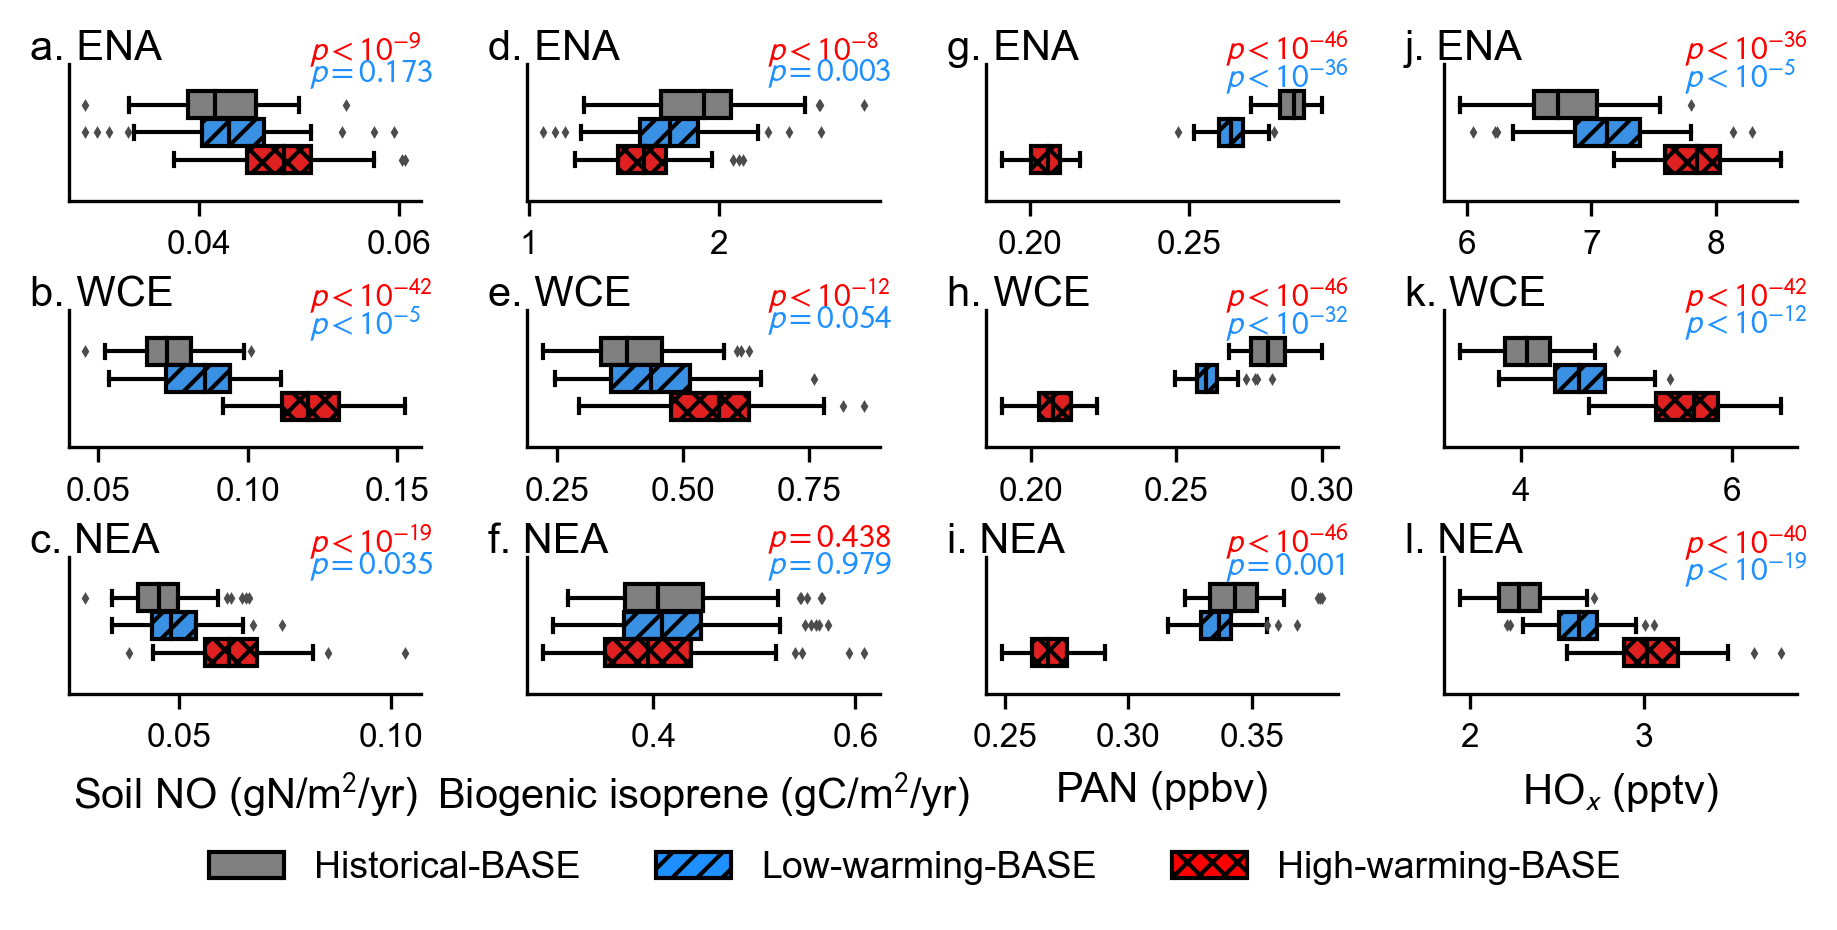

In [9]:
tools.set_matplotlib_font("Arial")

fig = plt.figure(figsize=(6, 3.0), dpi=300)

outer_gs = gridspec.GridSpec(
    1, 4, figure=fig,
    top=0.93, bottom=0.23, left=0.03, right=0.99,
    wspace=0.30, hspace=0.07, 
)
dfs = [EmisNO_Soil_df, EmisISOP_Biogenic_df, SpeciesConc_PAN_df, SpeciesConc_HOx_df]
PROPS = {
    'boxprops': {'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k'}
}
my_variables = ['EmisNO_Soil', 'EmisISOP_Biogenic', 'SpeciesConc_PAN', 'SpeciesConc_HOx']
xlabels = [
    r"Soil NO (gN/m$^2$/yr)",
    r"Biogenic isoprene (gC/m$^2$/yr)",
    r"PAN (ppbv)",
    r"HO$_x$ (pptv)",
]
colors = ["grey", "dodgerblue", "red"]
regions = ['ENA', 'WCE', 'NEA']
titles = ["a. ENA", "b. WCE", "c. NEA", "d. ENA", "e. WCE", "f. NEA", "g. ENA", "h. WCE", "i. NEA", "j. ENA", "k. WCE", "l. NEA"]

# Compute global x-axis limits for each variable across all regions (not used)
global_xlims = {}
for variable, df in zip(my_variables, dfs):
    global_min = df[variable].min()
    global_max = df[variable].max()
    padding = (global_max - global_min) * 0.05  # add 5% padding
    global_xlims[variable] = (global_min - padding, global_max + padding)


for outer_ind in range(4):
    
    row = outer_ind // 2
    col = outer_ind % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0, outer_ind], hspace=0.8, wspace=0.08)
    
    df = dfs[outer_ind]
    variable = my_variables[outer_ind]
    xlabel = xlabels[outer_ind]

    
    for inner_ind in range(3):
        global_idx = outer_ind * 3 + inner_ind
        ax = fig.add_subplot(inner_gs[inner_ind, 0])
        region = regions[inner_ind]
        data = df[df.region_name == region]

        a = sns.boxplot(
            x=variable, y="region_name", ax=ax,
            hue="name", palette=colors, width=0.6, whis=1.2, linewidth=1, fliersize=0.8,
            data=data, **PROPS, 
        )

        #ax.set_xlim(global_xlims[variable]) # for same x-lims per col (optional)

        hatches = ['////', '', 'xxxx', '////', '', 'xxxx']
        for i, bar in enumerate(a.patches):
            if i < len(hatches):
                bar.set_hatch(hatches[i])

        p_pd = data[data.name == 'Historical'].dropna()
        f_pd = data[data.name == 'High-warming'].dropna()
        fp_pd = data[data.name == 'Low-warming'].dropna()

        _, f_pval_ks = stats.ks_2samp(p_pd[variable], f_pd[variable])
        _, fp_pval_ks = stats.ks_2samp(p_pd[variable], fp_pd[variable])

        def format_pval(pval):
            if pval < 1e-3:
                exponent = int(np.floor(np.log10(pval))) + 1  # conservative rounding
                return f"$p<10^{{{exponent}}}$"
            else:
                return f"$p={pval:.3f}$"

        formatted_f_pval_ks = format_pval(f_pval_ks)
        formatted_fp_pval_ks = format_pval(fp_pval_ks)

        ax.text(-0.11, 1.25, titles[global_idx],
                ha='left', va='top', transform=ax.transAxes, color='black', fontsize=10)
        ax.text(0.68, 1.25, formatted_f_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='red', fontsize=8)
        ax.text(0.68, 1.05, formatted_fp_pval_ks,
                ha='left', va='top', transform=ax.transAxes, color='dodgerblue', fontsize=8)

        ax.set_ylabel(None)
        ax.set_yticks(ax.get_yticks())
        ax.tick_params(axis='y', which='both', left=False)
        ax.set_yticklabels([], rotation=90, ha='center', va='center', fontsize=8)
        ax.spines[['right', 'top']].set_visible(False)
        ax.tick_params(axis='y', which='major', labelsize=10)
        ax.tick_params(axis='x', which='major', labelsize=8)
        ax.legend([], [], frameon=False)
        
        # Set xlabel only for the bottom subplot in each column
        if inner_ind == 2:
            ax.set_xlabel(xlabel, fontsize=10)
        else:
            ax.set_xlabel("")
 
categories = ["Historical-BASE", "Low-warming-BASE", "High-warming-BASE"]
colors = ["grey", "dodgerblue", "red"]
hatches = ["", "////", "xxxx"] 

legend_patches = []
for cat, color, hatch in zip(categories, colors, hatches):
    patch = patches.Patch(
        facecolor=color, 
        hatch=hatch,
        edgecolor="k", 
        linewidth=1,
        label=cat
    )
    legend_patches.append(patch)

fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=len(categories),
    bbox_to_anchor=(0.5, -0.02),
    frameon=False,
    fontsize=9
)

################
plt.savefig("Fig4_new.pdf")